In [1]:
import cohere
import os
from dotenv import load_dotenv
from sklearn.cluster import KMeans, DBSCAN, AffinityPropagation
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
load_dotenv(dotenv_path='.env')

True

In [3]:
# COHERE_API_KEY
co = cohere.Client(api_key=os.getenv('COHERE_API_KEY'))

In [4]:
# load data from csv
df = pd.read_csv('comments.csv')

In [5]:
df = df.dropna()

In [6]:
# remove non-english characters
df['comments'] = df['comments'].str.replace(r'[^a-zA-Z0-9\s]', '', regex=True)
df.head(10)

,Unnamed: 0,comments
0,0,You cant stop dancing when you hear this song ...
1,1,Bruno Mars is one of the top pop musicians gre...
2,2,Yo todos los das la escucho
3,3,Listening and dancing
4,4,10 years and this music will never be forgotten
5,5,You ever get into a mood at 250am and this son...
6,6,Cant believe this was a decade ago and its sti...
7,7,Wow Still LOVE it So uplifting yea
8,8,The urge to dance is irresistible when this so...
9,9,I love this so much when Im in the car with my...


In [7]:
comments = df['comments'].tolist()
comments

['You cant stop dancing when you hear this song After 9 years its still my favorite I love Bruno Mars He is one of the most talented artists of all time',
 'Bruno Mars is one of the top pop musicians great song',
 'Yo todos los das la escucho ',
 'Listening and dancing',
 '10 years and this music will never be forgotten ',
 'You ever get into a mood at 250am and this song just hits different and you can listen to it 20 times',
 'Cant believe this was a decade ago and its still as good as when it dropped This man is still one of the best entertainers of this era and will go down a legend',
 'Wow Still LOVE it So uplifting yea',
 'The urge to dance is irresistible when this song plays Even after 9 years it remains my favorite Bruno Mars is truly one of the most talented artists of all time',
 'I love this so much when Im in the car with my mum I play this all the time bc she loves it so much ',
 'Muito  bom  esse msica',
 'Im I the only one who thinks that Bruno sounds like Michael Jacks

In [9]:
def process_in_batches(texts, batch_size=100):
  responses = []
  for i in range(0, len(texts), batch_size):
    batch = texts[i:i + batch_size]
    response = co.embed(
      texts=batch,
      model='embed-english-v3.0',
      input_type='clustering'
    )
    responses.extend(response)
  return responses

In [10]:
# response = process_in_batches(comments)
response = co.embed(
  texts=comments,
  model='embed-english-v3.0',
  input_type='clustering'
)

In [11]:
embeddings = pd.DataFrame(response)
embeddings.to_csv('embed.csv', index=False)
embeddings.head(5)

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,0.027344,0.001926,-0.018127,-0.022812,-0.015129,-0.014366,-0.020721,-0.026413,0.040344,0.035400,...,0.031097,-0.011078,-0.010376,-0.015572,-0.026627,0.003901,-0.004978,-0.058777,-0.022156,0.005753
1,0.028076,-0.007278,0.004623,0.013733,-0.003239,-0.004623,0.040131,-0.009361,-0.011902,0.014153,...,0.043701,-0.011406,0.005554,0.009483,-0.008583,0.032104,-0.053223,-0.079590,-0.012383,-0.024460
2,-0.008713,0.000045,-0.052216,-0.025986,-0.007412,-0.023621,-0.001246,0.039795,0.031616,0.037323,...,0.036957,-0.027496,0.019608,-0.007168,0.032990,0.041473,-0.050537,-0.037170,-0.005894,-0.018875
3,0.022705,0.000841,-0.022842,-0.037598,-0.013741,0.010689,-0.017059,-0.007175,0.012817,0.041229,...,0.061279,-0.022003,-0.001797,-0.036713,-0.037872,-0.004356,-0.047150,-0.112793,-0.054688,0.005817
4,0.045685,0.000299,-0.058411,-0.115234,0.001249,-0.023300,-0.060364,0.024918,0.053528,0.026993,...,-0.001799,0.025772,-0.000032,-0.040192,-0.030609,0.008614,-0.016144,-0.073608,-0.059540,0.008636


In [8]:
embeddings = pd.read_csv('embed.csv')

X = np.array(embeddings)
X.shape

(1464, 1024)

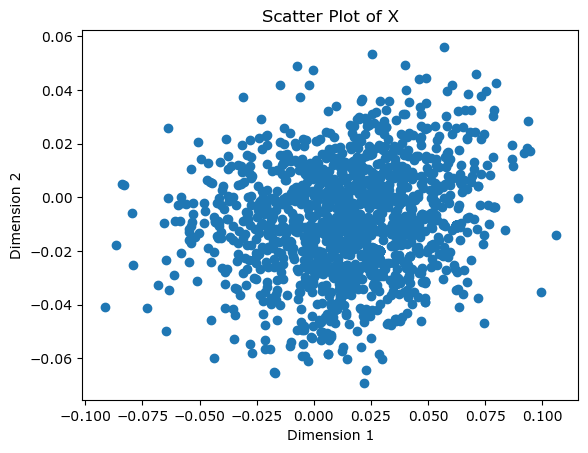

In [9]:
plt.scatter(X[:, 0], X[:, 1])
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Scatter Plot of X')
plt.show()

In [27]:
# cluster results
cluster = KMeans(n_clusters=10, random_state=0).fit(X)
# cluster = DBSCAN(eps=0.5, min_samples=5).fit(X)
# cluster = AffinityPropagation(random_state=42)
cluster_labels = cluster.fit_predict(X)
cluster_labels

c:\Users\ericz\miniconda3\envs\cc\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\ericz\miniconda3\envs\cc\lib\site-packages\joblib\externals\loky\backend\context.py:110: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\ericz\miniconda3\envs\cc\lib\site-packages\joblib\externals\loky\backend\context.py", line 217, in _count_physical_cores
    raise ValueError(
c:\Users\ericz\miniconda3\envs\cc\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks t

array([4, 4, 5, ..., 8, 7, 6])

In [28]:
df['cluster'] = cluster_labels

In [29]:
df.groupby('cluster').count()

,Unnamed: 0,comments
cluster,,
0,120,120
1,151,151
2,273,273
3,192,192
4,156,156
5,116,116
6,174,174
7,159,159
8,65,65


In [30]:
for i in range(len(df.cluster.unique())):
  print('Cluster {}:'.format(i))
  print(df.loc[df['cluster'] == i, 'comments'])
  print()

Cluster 0:
244     Remember watching this when it came out now on...
279     Dezembro De 2023 E Eu Aqui Pela No Sei L Quant...
285                                     2023 escuchandola
310                         2023 arrasando con este tema 
411     Its end of 2023 and still watching it One of t...
                              ...                        
1423                               Whos watching in 2023 
1426                                           Where 2023
1436                                Whos watching in 2023
1439                                             Dec 2023
1476                               Whos watching in 2023 
Name: comments, Length: 120, dtype: object

Cluster 1:
33      OkIm gonna give this video another 2 weeks and...
63      I only clicked on this cause i want it to get ...
75                       Its 2024 but this never gets old
86      I can so imagine myself 30 years from now lett...
88      Wow 9 years later and still giving me chills j...
      

In [32]:
# concatenate comments in each cluster into a single string
cluster_comments = []
for i in range(len(df.cluster.unique())):
  cluster_comments.append('\n'.join(df.loc[df['cluster'] == i, 'comments']))


In [33]:
import time

In [34]:
responses = []
for i in range(len(cluster_comments)):
  try:
    response = co.summarize(
        text=cluster_comments[i],
        model='command',
        length='short',
        extractiveness='medium'
    )
    response = "Summarized: " + response.summary
  except:
    response = "Original: " + cluster_comments[i]
  responses.append(response)
  # save to file
  with open('kmeans_summary.txt', 'a') as f:
    f.write('Cluster {}:'.format(i))
    f.write(response)
    f.write('\n\n')
  print()
  time.sleep(15) # "bypass" rate limit

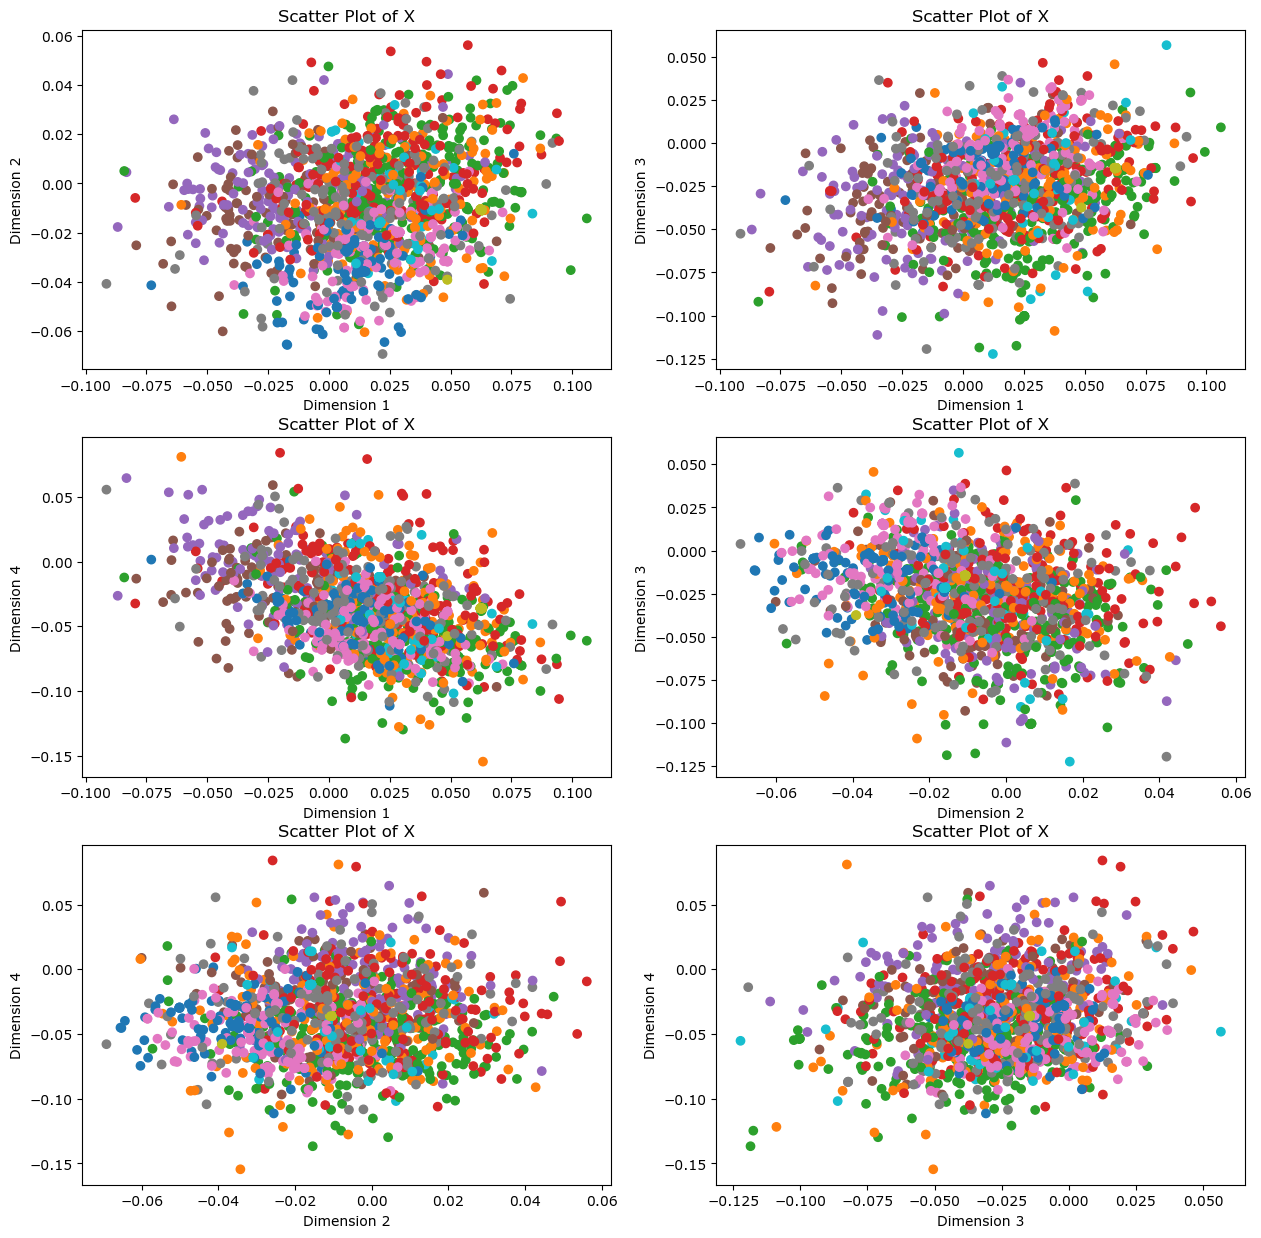

In [31]:
# plot the clusters with colors across different pairs of dimensions
from itertools import combinations

fig, axes = plt.subplots(3, 2, figsize=(15, 15))
for i, (x, y) in enumerate(combinations(range(4), 2)):
  ax = axes[i // 2, i % 2]
  ax.scatter(X[:, x], X[:, y], c=cluster_labels, cmap='tab10')
  ax.set_xlabel('Dimension {}'.format(x + 1))
  ax.set_ylabel('Dimension {}'.format(y + 1))
  ax.set_title('Scatter Plot of X')
plt.show()
